In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), device

(0, device(type='cpu'))

In [2]:
import os
import sys
IS_GCOLAB = 'google.colab' in sys.modules

In [3]:
from pathlib import Path

_base_libpath = Path(
    "/content/drive/MyDrive" if IS_GCOLAB else f"{os.environ['HOME']}"
) / "_self_research/24.09.world_cuisine"
assert _base_libpath.exists()

os.chdir(_base_libpath)

In [4]:
if IS_GCOLAB:
    raise NotImplementedError()
    # from google.colab import drive
    # drive.mount('/content/drive')
    # # os.environ.setdefault("", "1")
    # # os.system("pip install transformers==4.33.1")
    # os.system("pip install transformers sudachitra accelerate")
    # os.system("pip install langchain tiktoken openai")
    # os.system("pip install -U langchain-community")
    # os.system("pip install -U datasets pyarrow")

else:
    # raise NotImplementedError()
    print(">>> Not on Google Colab <<<")

>>> Not on Google Colab <<<


---

In [5]:
# import datasets
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from sentence_transformers import SentenceTransformer

import os
import requests
import pickle
from PIL import Image
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd

import time
from tqdm import tqdm

In [6]:
df = pd.read_csv("WorldCuisines - Food.csv")
df = df.loc[df.loc[:,'Image1 name / URL'].notna()].reset_index(drop=True)

In [27]:
fps = []
for _ in range(1,9):
    wew = df.loc[:,f"Image{_} name / URL"].dropna()
    fps.extend(wew.tolist())
fps = pd.Series(fps)

In [29]:
wew = fps.map(lambda t: t[:-len("?download")].lower() if t.endswith("?download") else t.lower())
assert not wew[~(
    wew.str.endswith(".jpg") | wew.str.endswith(".jpeg")
    | wew.str.endswith(".png") | wew.str.endswith(".gif")
)].tolist()
print(len(wew), len(wew.unique()))

1871 1856


In [30]:
print(len(fps))
fps = fps[~wew.duplicated()].reset_index(drop=True)
print(len(fps))

1871
1856


---

In [31]:
# assert all(fps[fps.str.startswith("http")].str.startswith("https://"))

In [35]:
def get_img_size(fp):
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    try:
        if fp.startswith("https://"):
            response = requests.get(fp, headers=headers, stream=True, timeout=8)
            response.raise_for_status()
            _img = response.raw
        else:
            _img = _base_libpath / "images" / fp
        image = Image.open(_img).convert('RGB')
        return image.size
    except Exception as e:
        # print(fp, e)
        return None

In [36]:
from multiprocessing import Pool

In [72]:
%%time
with Pool(processes=32) as pool:
    async_result = pool.map_async(get_img_size, fps.tolist(), 16)
    async_result.wait()

CPU times: user 59.1 ms, sys: 211 ms, total: 271 ms
Wall time: 26.5 s


In [73]:
sizes = async_result.get()

In [74]:
len(sizes), len(list(filter(None, sizes))), f"{len(list(filter(None, sizes)))/len(sizes):.1%}"

(1856, 1833, '98.8%')

---

In [78]:
import seaborn as sns

In [75]:
df = pd.DataFrame(list(filter(None, sizes)), columns=["width", "height"])

In [76]:
df

,width,height
0,1920,1440
1,1531,1198
2,1564,1199
3,1920,1285
4,1920,1440
...,...,...
1828,2048,1273
1829,1280,960
1830,1440,1080
1831,1434,1080


In [141]:
df["hue"] = ""

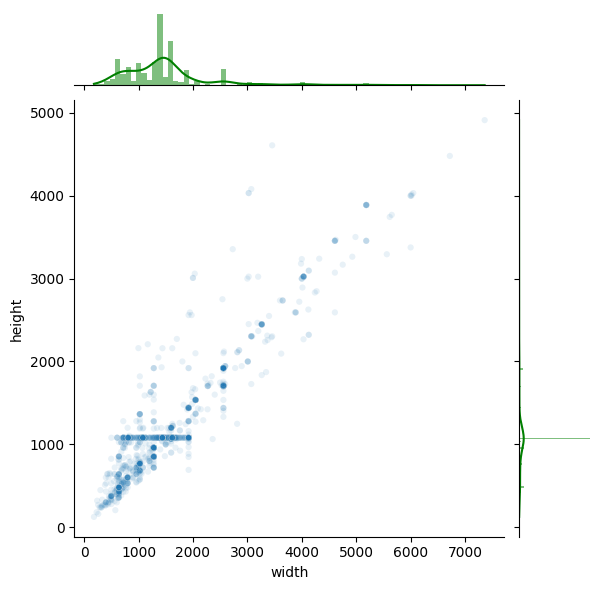

In [146]:
g = sns.JointGrid(df, x="width", y="height", hue="hue")
g.plot_joint(sns.scatterplot, s=20, alpha=.1)
g.plot_marginals(sns.histplot, kde=True, linewidth=0, palette=["g"])

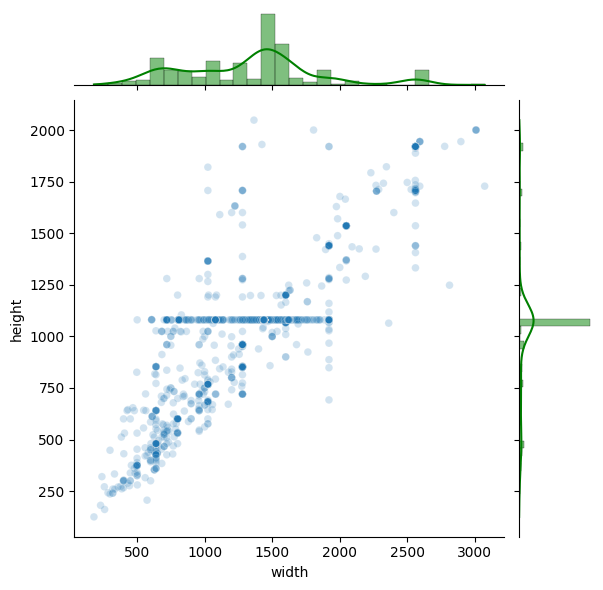

In [147]:
g = sns.JointGrid(df.loc[df.width.le(3072)&df.height.le(2048)], x="width", y="height", hue="hue")
g.plot_joint(sns.scatterplot, s=30, alpha=.2)
g.plot_marginals(sns.histplot, kde=True, linewidth=.2, palette=["g"])